## **Medical Image Processing**
### Lab 3 - Deep Learning


In [1]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ---------------------------------------------- Part #3 ----------------------------------------------

**1. Install useful libraries and U-Net definition**


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Show versioning of deep learning libraries
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.8.0+cu126 True


In [4]:
# Directory that contains all the data/script of this lab
current_dir = '/content/drive/MyDrive/Colab Notebooks/eim/lab3'

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """Applies two consecutive conv-batchnorm-relu layers"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self,
                 in_channels=3,
                 out_channels=1,
                 init_filters=64,
                 depth=4,
                 bilinear=True):
        super(UNet, self).__init__()
        self.depth = depth
        self.down_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)

        # Encoder
        filters = init_filters
        for d in range(depth):
            conv = DoubleConv(in_channels, filters)
            self.down_layers.append(conv)
            in_channels = filters
            filters *= 2

        # Bottleneck
        self.bottleneck = DoubleConv(in_channels, filters)

        # Decoder
        for d in range(depth):
            filters //= 2
            if bilinear:
                up = nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                    nn.Conv2d(filters * 2, filters, kernel_size=1)
                )
            else:
                up = nn.ConvTranspose2d(filters * 2, filters, kernel_size=2, stride=2)
            self.up_layers.append(nn.ModuleDict({
                'up': up,
                'conv': DoubleConv(filters * 2, filters)
            }))

        # Output layer
        self.out_conv = nn.Conv2d(init_filters, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.down_layers:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        for i in range(self.depth):
            skip = skip_connections[-(i+1)]
            up = self.up_layers[i]['up'](x)
            if up.size() != skip.size():
                # Resize in case of odd size mismatch
                up = F.interpolate(up, size=skip.shape[2:])
            x = torch.cat([skip, up], dim=1)
            x = self.up_layers[i]['conv'](x)

        return self.out_conv(x)

**2. Load the configuration and weights of the trained U-Net model**

In [6]:
import json
import torch

def load_model_from_checkpoint(checkpoint_dir, epoch_to_load):
    # Path to the JSON file with saved parameters
    params_path = os.path.join(checkpoint_dir, 'training_params.json')

    # Load parameters from JSON
    with open(params_path, 'r') as f:
        params = json.load(f)

    print("Loaded parameters:", params)

    # Create the model using the loaded parameters
    model = UNet(
        in_channels=params['in_channels'],
        out_channels=params['out_channels'],
        init_filters=params['init_filters'],
        depth=params['depth']
    )

    # Path to the checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch_to_load}.pt")

    # Load model state
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"Checkpoint for epoch {epoch_to_load} loaded from {checkpoint_path}")

    return model, params

In [7]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/eim/lab3/checkpoints'  # directory where checkpoints were saved
epoch_number = 10  # epoch to load

model, params = load_model_from_checkpoint(checkpoint_dir, epoch_number)
input_size = tuple(params["input_size"])

Loaded parameters: {'input_size': [256, 256], 'in_channels': 3, 'out_channels': 1, 'init_filters': 32, 'depth': 3, 'n_epochs': 10, 'batch_size': 4, 'learning_rate': 0.001, 'checkpoint_freq': 1}
Checkpoint for epoch 10 loaded from /content/drive/MyDrive/Colab Notebooks/eim/lab3/checkpoints/model_epoch_10.pt


**3. Apply trained model to the test set**




In [8]:
from torchvision import transforms

# Define paths
test_images_dir = os.path.join(current_dir, 'HAM1000', 'test', 'image')
test_manual_masks_dir = os.path.join(current_dir, 'HAM1000', 'test', 'manual')
output_masks_dir = os.path.join(current_dir,'HAM1000','test','unet_mask')
debug_dir = os.path.join(current_dir,'HAM1000','test','debug_unet')

# Create output folders if not present
os.makedirs(output_masks_dir, exist_ok=True)
os.makedirs(debug_dir, exist_ok=True)

# Send model to device and set to eval
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# Preprocessing: Resize and convert to tensor
preprocess = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

# List test image files (assumes .png/.jpg/.jpeg)
image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for img_name in image_files:
    img_path = os.path.join(test_images_dir, img_name)
    manual_mask_path = os.path.join(test_manual_masks_dir, img_name)

    # Load image and mask
    image = Image.open(img_path).convert('RGB')
    manual_mask = Image.open(manual_mask_path).convert('L')

    # Preprocess image
    input_tensor = preprocess(image).unsqueeze(0).to(device)  # batch dimension

    # Inference
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.sigmoid(output).cpu().squeeze().numpy()

    # Binarize prediction with th = 0.5
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8) * 255

    # Save predicted mask
    pred_mask_img = Image.fromarray(pred_mask_bin)
    pred_mask_img.save(os.path.join(output_masks_dir, img_name))

    # Create debug figure
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(manual_mask, cmap='gray')
    axs[1].set_title("Manual Mask")
    axs[1].axis('off')

    axs[2].imshow(pred_mask_bin, cmap='gray')
    axs[2].set_title("Predicted Mask (UNet)")
    axs[2].axis('off')

    debug_path = os.path.join(debug_dir, img_name)
    plt.savefig(debug_path, bbox_inches='tight')
    plt.close(fig)

**4.	Compute quantitative metrics**

In [9]:
# Same function of part #1
def compute_binary_metrics(manual_mask, auto_mask):

    manual_mask = manual_mask > 0
    auto_mask = auto_mask > 0

    assert manual_mask.shape == auto_mask.shape, "Masks must have the same shape"

    TP = np.sum(manual_mask & auto_mask)
    FP = np.sum(~manual_mask & auto_mask)
    TN = np.sum(~manual_mask & ~auto_mask)
    FN = np.sum(manual_mask & ~auto_mask)

    epsilon = 1e-7

    IoU = TP / (TP + FP + FN + epsilon)
    Dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    Precision = TP / (TP + FP + epsilon)
    Recall = TP / (TP + FN + epsilon)
    Accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)

    return IoU, Dice, Precision, Recall, Accuracy

45it [00:18,  2.46it/s]


IoU: mean 0.333 std 0.184
Dice: mean 0.471 std 0.211
Precision: mean 0.578 std 0.282
Recall: mean 0.600 std 0.325
Accuracy: mean 0.758 std 0.127


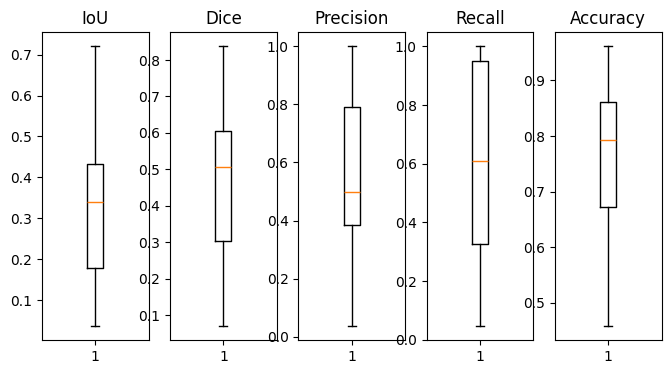

In [10]:
# List of test images with their manual and automatic masks
path_mask_manual = os.path.join(current_dir,'HAM1000','test','manual_py')
path_mask_auto = os.path.join(current_dir,'HAM1000','test','unet_mask')
list_mask_manual = [os.path.join(path_mask_manual, f) for f in os.listdir(path_mask_manual) if f.endswith('.png')]
list_mask_auto = [os.path.join(path_mask_auto, f) for f in os.listdir(path_mask_auto) if f.endswith('.png')]

# Initialize metrics lists
IoUs, Dices, Precisions, Recalls, Accuracies = [], [], [], [], []

for manual_mask_path, auto_mask_path in tqdm(zip(list_mask_manual, list_mask_auto)):

    # Load masks
    manual_mask = np.array(Image.open(manual_mask_path))
    auto_mask = np.array(Image.open(auto_mask_path))

    # Compute metrics
    IoU, Dice, Precision, Recall, Accuracy = compute_binary_metrics(manual_mask, auto_mask)

    # Append metrics to lists
    IoUs.append(IoU)
    Dices.append(Dice)
    Precisions.append(Precision)
    Recalls.append(Recall)
    Accuracies.append(Accuracy)

# Print mean and standard deviation of metrics
print("IoU: mean {:.3f} std {:.3f}".format(np.nanmean(IoUs), np.nanstd(IoUs)))
print("Dice: mean {:.3f} std {:.3f}".format(np.nanmean(Dices), np.nanstd(Dices)))
print("Precision: mean {:.3f} std {:.3f}".format(np.nanmean(Precisions), np.nanstd(Precisions)))
print("Recall: mean {:.3f} std {:.3f}".format(np.nanmean(Recalls), np.nanstd(Recalls)))
print("Accuracy: mean {:.3f} std {:.3f}".format(np.nanmean(Accuracies), np.nanstd(Accuracies)))

# Create boxplots for the metrics
fig, ax = plt.subplots(1, 5, figsize=(8, 4))
ax[0].boxplot(IoUs)
ax[0].set_title("IoU")
ax[1].boxplot(Dices)
ax[1].set_title("Dice")
ax[2].boxplot(Precisions)
ax[2].set_title("Precision")
ax[3].boxplot(Recalls)
ax[3].set_title("Recall")
ax[4].boxplot(Accuracies)
ax[4].set_title("Accuracy")
plt.show()